In [2]:
!pip install gensim

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
  Using cached gensim-4.0.1-cp37-cp37m-manylinux1_x86_64.whl (23.9 MB)


In [4]:
!pip install pyLDAvis

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
     |████████████████████████████████| 1.7 MB 29.4 MB/s eta 0:00:01
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 1:
   command: /home/ubuntu/anaconda3/envs/pytorch_latest_p37/bin/python3.7 /home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/pip install --ignore-installed --no-user --prefix /tmp/pip-build-env-sc1nrt27/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- setuptools
       cwd: None
  Complete output (42 lines):
  Traceback (most recent call last):
    File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/h

In [85]:
import pandas as pd
import numpy as np
import sklearn

#gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

#nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Load data

In [74]:
data = pd.read_csv('data/tweet_text.csv', error_bad_lines=False)
data_text = data[['text']]
data_text['index'] = data_text.index
documents = data_text

In [98]:
data.shape

(16180, 1)

#### Pre-process data

In [75]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [76]:
stemmer = SnowballStemmer('english')
processed_docs = documents['text'].map(preprocess)

#### Bag of Words

In [126]:
#create dictionary
# dictionary = Dictionary(processed_docs)

# dictionary.filter_extremes(no_below=20, no_above=0.5) #testing this

id2word = gensim.corpora.Dictionary(processed_docs)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(bow_corpus))

#create corpus
texts = processed_docs

#Term Document Frequency
bow_corpus = [id2word.doc2bow(text) for text in texts]

Number of unique tokens: 1149
Number of documents: 16180


In [103]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in bow_corpus]

[[('care', 1),
  ('go', 1),
  ('jeremynewberg', 1),
  ('marklevinshow', 1),
  ('petehegseth', 1)],
 [('go', 1),
  ('claim', 1),
  ('court', 1),
  ('crowd', 1),
  ('deliber', 1),
  ('fals', 1),
  ('fight', 1),
  ('fraud', 1),
  ('hawleymo', 1),
  ('incit', 1),
  ('play', 1),
  ('resign', 1),
  ('rhetor', 1),
  ('simonschust', 1),
  ('statement', 1),
  ('stopthest', 1),
  ('theater', 1),
  ('voter', 1),
  ('word', 1),
  ('yell', 1)],
 [('stopthest', 1),
  ('americafirst', 1),
  ('auditallvot', 1),
  ('frznsoonrmn', 1),
  ('great', 1),
  ('love', 1),
  ('missilmom', 1),
  ('presid', 1),
  ('video', 1),
  ('wish', 1)],
 [('stopthest', 1),
  ('presid', 1),
  ('apolog', 1),
  ('biden', 1),
  ('eagleedmartin', 1),
  ('gfzt', 1),
  ('httpstcoobiy', 1),
  ('joebiden', 1),
  ('peopl', 1),
  ('periscop', 1),
  ('pledg', 1),
  ('plus', 1),
  ('power', 1),
  ('say', 1),
  ('unit', 1),
  ('wynk', 1)],
 [('stopthest', 1),
  ('cointuckeywind', 1),
  ('freemont', 1),
  ('godjesush', 1),
  ('johnnyrwhit

In [146]:
lda_model = gensim.models.LdaMulticore(bow_corpus, alpha=.01, eta=.1, eval_every=1, random_state=123, num_topics=20, chunksize=100, id2word=id2word, passes=20, iterations=400, workers=6)

In [131]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(bow_corpus, alpha=.1, eval_every=1, random_state=123, num_topics=num_topics, chunksize=100, id2word=id2word, passes=20, iterations=400, workers=6)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

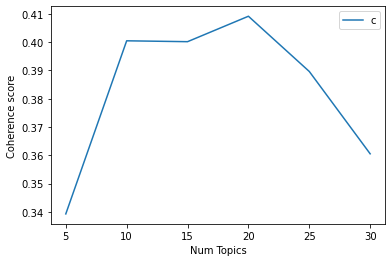

In [132]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=bow_corpus, texts=processed_docs, start=5, limit=35, step=5)
# Show graph

limit=35; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('data/num_topics_search.png')
plt.show()

In [99]:
# model = LdaModel(
#     corpus=corpus,
#     id2word=id2word,
#     chunksize=chunksize,
#     alpha='auto',
#     eta='auto',
#     iterations=iterations,
#     num_topics=num_topics,
#     passes=passes,
#     eval_every=eval_every
# )

#### View Topics

In [114]:
from pprint import pprint

# Print the Keyword in the topics

# pprint(lda_model.print_topics())
# doc_lda = lda_model[bow_corpus]
#pprint(list(lda_model.get_document_topics(bow_corpus)))  # can use min_probability param to limit list
#pprint(list(lda_model.get_term_topics(##need word_id##)))

pprint(list(lda_model.top_topics(bow_corpus)))

#maybe choose some interesting words and look at their most relevant topics

[([(0.12461927, 'capitol'),
   (0.10222181, 'stopthest'),
   (0.06336838, 'trump'),
   (0.053999472, 'washington'),
   (0.04981373, 'build'),
   (0.031184768, 'januari'),
   (0.021927562, 'patriot'),
   (0.02178492, 'support'),
   (0.019112118, 'fightback'),
   (0.017508073, 'attack'),
   (0.017140467, 'break'),
   (0.016882816, 'antifa'),
   (0.016262904, 'voterfraud'),
   (0.013110833, 'terrorist'),
   (0.012303546, 'congress'),
   (0.011037666, 'rsbnetwork'),
   (0.010444803, 'breach'),
   (0.010429274, 'capitolbuild'),
   (0.010307307, 'maga'),
   (0.009982287, 'tear')],
  -4.7668576310108906),
 ([(0.09706395, 'steal'),
   (0.09679352, 'peopl'),
   (0.08755303, 'american'),
   (0.07703914, 'elect'),
   (0.07071965, 'stopthest'),
   (0.05184463, 'tri'),
   (0.045098413, 'world'),
   (0.038475957, 'trump'),
   (0.029871829, 'person'),
   (0.02506298, 'httpstcoi'),
   (0.024642523, 'entir'),
   (0.024582705, 'trumpral'),
   (0.024395773, 'sit'),
   (0.024198772, 'realdonaldtrump'),
  

In [147]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.46365180919436

Coherence Score:  0.4241739382627615


In [148]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
pyLDAvis.save_html(vis, 'images/LDAvis_20_eta5.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.188295  0.104293       1        1  11.664935
3      0.151380 -0.173087       2        1  11.189403
14     0.128482  0.109660       3        1   9.311479
8      0.172554  0.084957       4        1   8.546436
7      0.088817 -0.065584       5        1   7.220781
5      0.116205 -0.118404       6        1   6.299147
9      0.090241 -0.007076       7        1   6.058372
10     0.047750  0.058913       8        1   5.870228
19     0.002721  0.054718       9        1   4.435023
16    -0.013089  0.079269      10        1   4.345154
13     0.004060 -0.087780      11        1   4.323668
0      0.015758 -0.129231      12        1   4.253035
11    -0.049264  0.130220      13        1   3.133477
6     -0.107698 -0.056235      14        1   2.496872
2     -0.095372  0.016026      15        1   2.289661
17    -0.135399 -0.025895      16        1   2.095043
1     -0.117228  0.001462      17        1   2.058492
18    -0.138796  0.014975      18        1   1.907411
15    -0.151550  0.018957      19        1   1.739357
4     -0.197867 -0.010157      20        1   0.762024, topic_info=                 Term         Freq         Total Category  logprob  loglift
61              trump  3700.000000   3700.000000  Default  30.0000  30.0000
154             elect  2155.000000   2155.000000  Default  29.0000  29.0000
437              vote  1261.000000   1261.000000  Default  28.0000  28.0000
423   realdonaldtrump  2232.000000   2232.000000  Default  27.0000  27.0000
1156    marchfortrump   637.000000    637.000000  Default  26.0000  26.0000
...               ...          ...           ...      ...      ...      ...
1624            earli     8.339192     18.479309  Topic20  -5.1002   4.0813
3426         suppress     5.845828     12.986943  Topic20  -5.4554   4.0787
2413           werent     4.429822     17.851072  Topic20  -5.7328   3.4832
19          stopthest    11.351349  13766.332802  Topic20  -4.7918  -2.2237
2584             self     3.739986     11.602539  Topic20  -5.9021   3.7448

[1143 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
2894       3  0.943924      abl
259       13  0.886920  absolut
259       15  0.078258  absolut
2971       4  0.088259   accept
2971      11  0.907810   accept
...      ...       ...      ...
428       10  0.109986   youtub
428       12  0.047137   youtub
428       14  0.015712   youtub
428       19  0.007856   youtub
11113     18  0.879228     zijn

[2148 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 15, 9, 8, 6, 10, 11, 20, 17, 14, 1, 12, 7, 3, 18, 2, 19, 16, 5])